In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

code_root='/home/nileshk/Research3/3dRelnet/relative3d'
import sys
import numpy as np
import os.path as osp
import scipy.misc
import scipy.io as sio
import torch
import matplotlib.pyplot as plt
sys.path.append(osp.join(code_root, '..'))
import pdb
from absl import flags
from relative3d.demo import demo_utils
import cPickle as pkl

In [11]:

flags.FLAGS(['demo'])
opts =  flags.FLAGS
opts.batch_size = 1
opts.num_train_epoch = 8
opts.name = 'nyu_relnet_dwr_pos_ft'
opts.classify_rot = True
opts.classify_dir = True
opts.pred_voxels = False
opts.use_context = True
# opts.pred_label = False
opts.upsample_mask=True
opts.pred_relative=True
opts.use_mask_in_common=True
opts.use_spatial_map=True
opts.pred_labels=False
opts.pretrained_shape_decoder=True
opts.do_updates=True
opts.dwr_model=True


In [13]:
if opts.classify_rot:
    opts.nz_rot = 24
else:
    opts.nz_rot = 4



checkpoint = '../cachedir/snapshots/{}/pred_net_{}.pth'.format(opts.name, opts.num_train_epoch)
pretrained_dict = torch.load(checkpoint)


# renderer = demo_utils.DemoRenderer(opts)
## Load input data



def clean_checkpoint_file(ckpt_file):
    checkpoint = torch.load(ckpt_file)
    keys = checkpoint.keys()
    
    temp = [key for key in keys if 'relative_quat_predictor' in key ] +  [key for key in keys if 'relative_encoder.encoder_joint_scale' in key]
    if len(temp) > 0:
        for t in temp:
            checkpoint.pop(t)

#         with open(ckpt_file, 'w') as f:
#             pkl.dump(f, checkpoint)
        torch.save(checkpoint, ckpt_file)
    

In [5]:
ckpt_file = '../cachedir/snapshots/{}/pred_net_{}.pth'.format(opts.name, opts.num_train_epoch)
clean_checkpoint_file(ckpt_file)
tester = demo_utils.DemoTester(opts)
tester.init_testing()



Loading weights from /home/nileshk/Research3/3dRelnet/relative3d/nnutils/../cachedir/snapshots/rebt_nyu_dwr_mask_common_spatial_pos_ft/pred_net_8.pth
Loading shape decoder pretrained
Loading weights from /home/nileshk/Research3/3dRelnet/relative3d/nnutils/../cachedir/snapshots/object_autoenc_32/decoder_net_800.pth
Loading weights from /home/nileshk/Research3/3dRelnet/relative3d/nnutils/../cachedir/snapshots/layout_pred/pred_net_8.pth
Loading weights from /home/nileshk/Research3/3dRelnet/relative3d/nnutils/../cachedir/snapshots/pretrained_dwr_shape_ft/pred_net_1.pth
Loading weights from /home/nileshk/Research3/3dRelnet/relative3d/nnutils/../cachedir/snapshots/object_autoenc_32/decoder_net_800.pth


In [6]:
dataset = 'nyu'

img = scipy.misc.imread('./data/{}_img.png'.format(dataset))

img_fine = scipy.misc.imresize(img, (opts.img_height_fine, opts.img_width_fine))
img_fine = np.transpose(img_fine, (2,0,1))

img_coarse = scipy.misc.imresize(img, (opts.img_height, opts.img_width))
img_coarse = np.transpose(img_coarse, (2,0,1))


# proposals = sio.loadmat('./data/{}_proposals.mat'.format(dataset))['proposals'][:, 0:4]
proposals_data = sio.loadmat('./data/{}_proposals.mat'.format(dataset))
scores = proposals_data['score']
proposals = proposals_data['boxes'][:,0:4]
inputs = {}
inputs['img'] = torch.from_numpy(img_coarse/255.0).unsqueeze(0)
inputs['img_fine'] = torch.from_numpy(img_fine/255.0).unsqueeze(0)
inputs['bboxes'] = [torch.from_numpy(proposals)]
inputs['scores'] = [torch.from_numpy(scores)]
inputs['empty'] = False


/home/nileshk/anaconda2/envs/3drelNet/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nileshk/anaconda2/envs/3drelNet/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """
/home/nileshk/anaconda2/envs/3drelNet/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


In [14]:
tester.set_input(inputs)
objects = tester.predict_box3d()
visuals = tester.render_outputs()

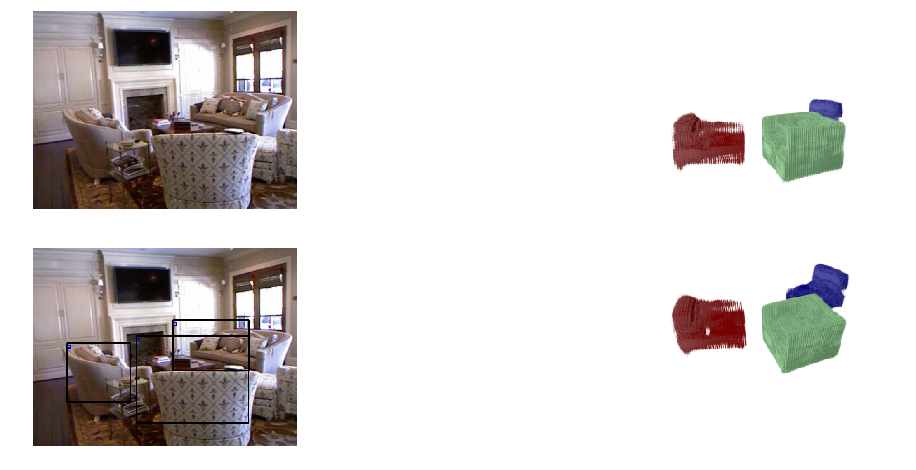

In [8]:
f, axarr = plt.subplots(2, 2, figsize=(20, 8))



axarr[0, 0].imshow(visuals['img'])
axarr[0, 0].axis('off')
axarr[0, 1].imshow(visuals['b_pred_objects_cam_view'])
axarr[0, 1].axis('off')
axarr[1, 0].imshow(visuals['img_roi'])
axarr[1, 0].axis('off')
axarr[1, 1].imshow(visuals['b_pred_scene_cam_view'])
axarr[1, 1].axis('off')
plt.show()